# Direct Transition (Microwave)


## Atomic Circuit


In [1]:
import numpy as np
from oqd_core.interface.atomic import (  # noqa: F401
    AtomicCircuit,
    Beam,
    ParallelProtocol,
    Phonon,
    Pulse,
    System,
    Yb171IIBuilder,
)

chain = [Yb171IIBuilder().build(["q1", "e0"]), Yb171IIBuilder().build(["q1", "e0"])]
COM_x = Phonon(
    energy=2 * np.pi * 1e6, eigenvector=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2), 0, 0]
)
system = System(
    ions=chain,
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition="q1->e0",
    rabi=2 * np.pi * 3e5,
    detuning=-2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 0, 1],
    wavevector=[1, 0, 0],
    target=0,
)

beam2 = Beam(
    transition="q1->e0",
    rabi=2 * np.pi * 3e5,
    detuning=2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 0, 1],
    wavevector=[1, 0, 0],
    target=0,
)

beam3 = Beam(
    transition="q1->e0",
    rabi=2 * np.pi * 3e5,
    detuning=-2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 0, 1],
    wavevector=[1, 0, 0],
    target=1,
)

beam4 = Beam(
    transition="q1->e0",
    rabi=2 * np.pi * 3e5,
    detuning=2 * np.pi * 1.1e6,
    phase=0,
    polarization=[0, 0, 1],
    wavevector=[1, 0, 0],
    target=1,
)


protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=1e-3),
        Pulse(beam=beam2, duration=1e-3),
        Pulse(beam=beam3, duration=1e-3),
        Pulse(beam=beam4, duration=1e-3),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [2]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("4_molmer_sorensen.json", "w") as f:
    f.write(circuit_json)

In [3]:
with open("4_molmer_sorensen.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [4]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    RotatingReferenceFrame,
    RotatingWaveApprox,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    "E0": [level.energy for level in chain[0].levels],
    "E1": [level.energy for level in chain[1].levels],
    "P0": 2 * np.pi * 1e6,
}

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e9)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [5]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1})
    - E1: set({0, 1})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79437055201.61006 * |0><0|_E0 @ I_E1 @ I_P0 + 5097558624563474.0 * |1><1|_E0 @ I_E1 @ I_P0 + 79437055201.61006 * I_E0 @ |0><0|_E1 @ I_P0 + 5097558624563474.0 * I_E0 @ |1><1|_E1 @ I_P0 + 6283185.307179586 * I_E0 @ I_E1 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(942477.7960769379 * exp(1j * (6911504.0 * t)) * |1><0|_E0 @ I_E1 @ D(0.06537491988234984 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 942477.7960769379 * exp(1j * (-6911504.0 * t)) * |0><1|_E0 @ I_E1 @ D(0.06537491988234984 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)))_P0 + 942477.7960769379 * exp(1j * (-6911504.0 * t)) * |1><0|_E0 @ I_E1 @ D(0.06537492005962924 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 942477.7960769379 * exp(1j * (6911504.0 * t)) * |0><1|_E0 @ I_E1 @ D(0.065374920059

### Run


In [6]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-5,
)

10.0%. Run time:  20.91s. Est. time left: 00:00:03:08


20.0%. Run time:  42.25s. Est. time left: 00:00:02:49


30.0%. Run time:  63.54s. Est. time left: 00:00:02:28


40.0%. Run time:  84.90s. Est. time left: 00:00:02:07


50.0%. Run time: 106.00s. Est. time left: 00:00:01:45


60.0%. Run time: 127.64s. Est. time left: 00:00:01:25


70.0%. Run time: 149.17s. Est. time left: 00:00:01:03


80.0%. Run time: 170.63s. Est. time left: 00:00:00:42


90.0%. Run time: 192.34s. Est. time left: 00:00:00:21


100.0%. Run time: 214.65s. Est. time left: 00:00:00:00


Total run time: 214.65s


#### Results


In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

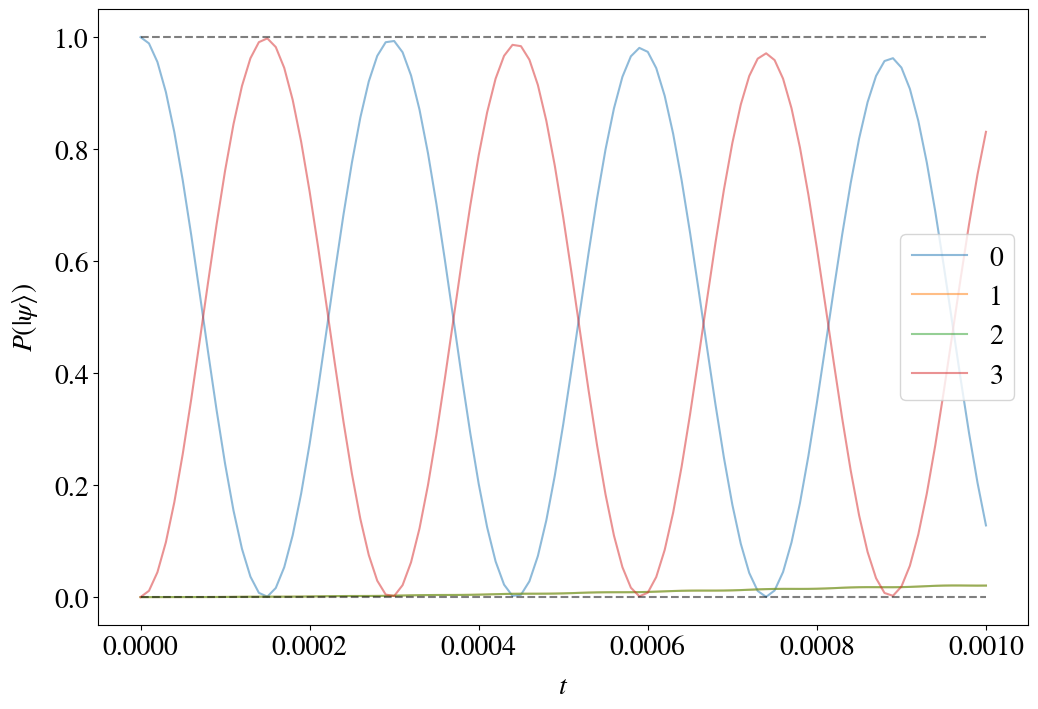

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)


state_labels = [0, 1, 2, 3]
plot_states = [
    [s.ptrace([0, 1]).diag()[i] for i in state_labels] for s in result["states"][k]
]

ax.plot(result["tspan"][k], plot_states, label=range(len(state_labels)), alpha=0.5)

ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

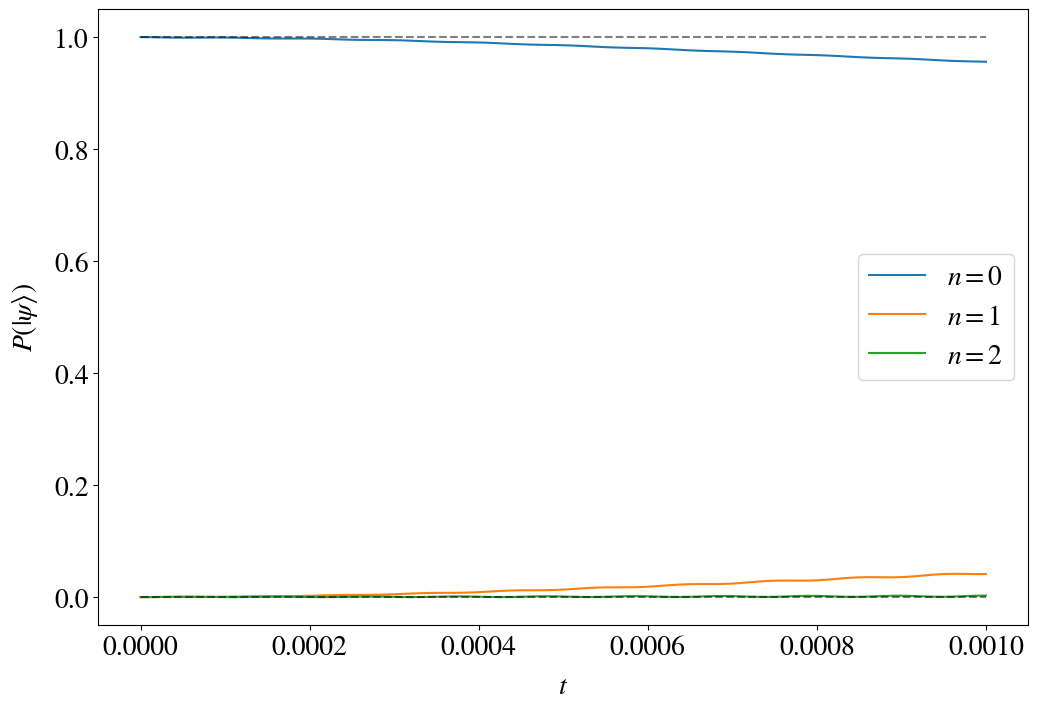

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(2).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()